# Авторегрессионные модели

На этом семинаре мы поработаем с авторегрессионными моделями на примере архитектуры PixelCNN. Мы обучим модель для задачи генерации изображений и для задачи дорисовывания недостающих частей изображения.

### LCD digits dataset

В качестве примера мы возьмем датасет из простых LCD-цифр. Ниже приведен код, который его загружает и рисует примеры сэмплов.

Источник датасета: https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

In [0]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets, utils
from torch.autograd import Variable

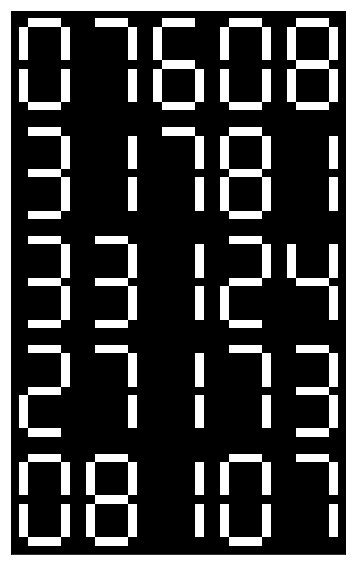

In [0]:
from utils import LcdDigits, IMAGE_WIDTH, IMAGE_HEIGHT

BATCH_SIZE = 100

train_dataset = LcdDigits(BATCH_SIZE * 50)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)


def show_as_image(image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.xticks([]); plt.yticks([])
    
def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

for batch, _ in train_loader:
    show_as_image(batch_images_to_one(batch[:25]), figsize=(10, 10))
    break

Здесь специально выбран простой датасет, так как вероятностные модели обычно требуют больших ресурсов. Также обратите внимание, что хотя данные очень простые (фактически всего 10 разных сэмплов), они находятся в пространстве значительно большей размерности ($2^{8 \times 13}$). Мы будем подавать модели сырые пиксели на вход, и будем хотеть, чтобы она нашла в них правильные зависимости и научилась строить только валидные изображения.

### PixelCNN

Коротко вспомним, что такое PixelCNN. Авторегрессионные модели в общем виде моделируют распределения на векторах $x = (x_1, \ldots, x_N)$ в виде:

$$
    p(x) = \prod_{i=1}^{N} p(x_i \mid x_1, \ldots, x_{i-1}).
$$

Распределения $p(x_i \mid x_1, \ldots, x_{i-1})$ можно моделировать при помощи нейронных сетей, которые получают на вход значения $x_1, \ldots, x_{i-1}$ и выдают распределение вероятностей для значений $x_i$. Так как входов здесь переменное число, можно использовать рекуррентные сети (например, PixelRNN), но неплохо работает и более простая модель &mdash; PixelCNN, &mdash; которая подает на вход не все значения $x_1, \ldots, x_{i-1}$, а только соседние на некотором расстоянии с помощью сверточных слоев.

![pixelcnn](pixelcnn.png)

**(0.3 балла)**

Для того, чтобы для данного пикселя подавать на вход только значения идущие ранее, вместо обычных сверток нужно использовать маскированные свертки. Напишите недостающий код, чтобы создать соответствующие маски и потом сделайте из них слой для pytorch. Такие слои можно добавлять последовательно, сохраняя корректные зависимости, при этом во всех слоях кроме первого можно использовать центральный пиксель. У вас должны получаться вот такие маски (с `include_center=False` и с `include_center=True` соответственно):

![](mask_no_center.png)
![](mask_with_center.png)

Hint: можно умножить на маску не входы, а веса.

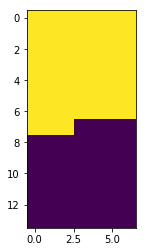

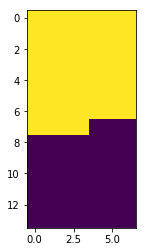

In [0]:
def causal_mask(width, height, starting_point):  # делает mask A, mask B
    z=np.ones((width,height))
    i, j = starting_point
    z[i + 1:,:] = 0.0
    z[i, j:] = 0.0
    

    #i, j = starting_point
    #i += 1
    #j += 1
    #k = (i - 1 ) * width + j
    #z[k:] = 0.0
    #return z.reshape((width, height))
    return z

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(
        width, height, 
        starting_point=(width//2, height//2 + include_center))

#plt.imshow(causal_mask(5, 5, (3,3))) # тест
plt.figure()
z = conv_mask(14, 7, False)
plt.imshow(z)
plt.show()


plt.figure()
z = conv_mask(14, 7, True)
plt.imshow(z)
plt.show()

In [0]:
class MaskedConv2d(nn.Conv2d): # модифицированная свертка: сначала внутри будет применена маска, потом уже сама свертка
    def __init__(self, include_center, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        #self.weights.size() = [1, n_ch, width, height]
        _, _, width, height = self.weight.size()
        print(self.weight.size())
        mask = conv_mask(width, height, include_center = include_center)
        self.mask = np.reshape(mask, (1, 1, width, height))
        self.mask = torch.from_numpy(mask).float()
    
    def forward(self,x):
        self.weight.data *= self.mask# так как wight - это ядро свертки
        
        return super(MaskedConv2d, self).forward(x)
    
z = MaskedConv2d(True, 1, 10, 7)    

torch.Size([10, 1, 7, 7])


In [0]:
#по поводу *args и **kwargs
def func(*args, **kwargs):
    print(len(args), type(args), *args)
    print(len(kwargs), type(kwargs), kwargs)
func(3,4,5, ppp=199, qq='hello')

3 <class 'tuple'> 3 4 5
2 <class 'dict'> {'ppp': 199, 'qq': 'hello'}


**(0.3 балла)**

Теперь соберите сеть с несколькими слоями маскированных сверток и обучите ее.

Hint 1: в задаче хорошо помогает сверточный слой 1x1 в конце.

Hint 2: если ошибиться и нарушить казуальность (т.е. сделать зависимости вперед), то обучаться будет хорошо, а генерировать плохо.

In [0]:
class PixelCNN(nn.Module):
    N_PIXELS_OUT = 2 # binary 0/1 pixels
    
    def __init__(self, n_channels, kernel_size, padding):
        super(PixelCNN, self).__init__()
        #здесь определяем layers
        self.layers = nn.Sequential(
            MaskedConv2d(False, in_channels = 1, out_channels = n_channels, 
                         kernel_size = kernel_size, padding = padding),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            
            MaskedConv2d(True, in_channels = n_channels, out_channels = n_channels, 
                         kernel_size = kernel_size, padding = padding),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            
            MaskedConv2d(True, in_channels = n_channels, out_channels = n_channels, 
                         kernel_size = kernel_size, padding = padding),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(n_channels, self.N_PIXELS_OUT, 1)
        )
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

In [0]:
N_EPOCHS = 25
LR = 0.005

cnn = PixelCNN(n_channels=4, kernel_size=7, padding=3)
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

torch.Size([4, 1, 7, 7])
torch.Size([4, 4, 7, 7])
torch.Size([4, 4, 7, 7])


Обратите внимание, что полученной сети достаточно подать на вход изображение, и на выходе получится распределение для значений каждого пикселя. Осталось только минимизировать кросс-энтропию этих значений и пикселей примеров в выборке. В случае успеха итоговая кросс-энтропия будет около 0.02.

In [0]:
import torch.nn.functional as F


for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images)
        optimizer.zero_grad()
        
         # YOUR CODE
        output = cnn(images)
        target = images
        output = output.permute(0, 2, 3, 1).contiguous().view((-1,2)) # меняем порядок осей, 0,1,2,3 - порядок осей, которые меняем местами
        target = target.permute(0, 2, 3, 1).contiguous().view((-1))
        loss = F.cross_entropy(output, target.long())
        # END CODE
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, N_EPOCHS, loss.data[0]))

Epoch [1/25], Loss: 0.8435
Epoch [2/25], Loss: 0.3470
Epoch [3/25], Loss: 0.1306
Epoch [4/25], Loss: 0.0548
Epoch [5/25], Loss: 0.0406
Epoch [6/25], Loss: 0.0346
Epoch [7/25], Loss: 0.0310
Epoch [8/25], Loss: 0.0287
Epoch [9/25], Loss: 0.0275
Epoch [10/25], Loss: 0.0267
Epoch [11/25], Loss: 0.0262
Epoch [12/25], Loss: 0.0257
Epoch [13/25], Loss: 0.0255
Epoch [14/25], Loss: 0.0253
Epoch [15/25], Loss: 0.0253
Epoch [16/25], Loss: 0.0250
Epoch [17/25], Loss: 0.0249
Epoch [18/25], Loss: 0.0249
Epoch [19/25], Loss: 0.0245
Epoch [20/25], Loss: 0.0246
Epoch [21/25], Loss: 0.0246
Epoch [22/25], Loss: 0.0242
Epoch [23/25], Loss: 0.0240
Epoch [24/25], Loss: 0.0242
Epoch [25/25], Loss: 0.0243


**(0.4 балла)**

При генерации изображений можно начинать с пустого изображения, а можно подавать какие-то начальные пиксели. Допишите функцию генерации и проверьте ее для задачи генерации (на вход пустое изображения) и для задачи дорисовывания (на вход - верхняя часть изображения).

У вас должны получиться разумные изображения цифр, допускается небольшая доля "плохих" изображений.

Hint: эффективно выполнять генерацию для этой модели не выйдет, нужно генерировать пиксели по очереди.

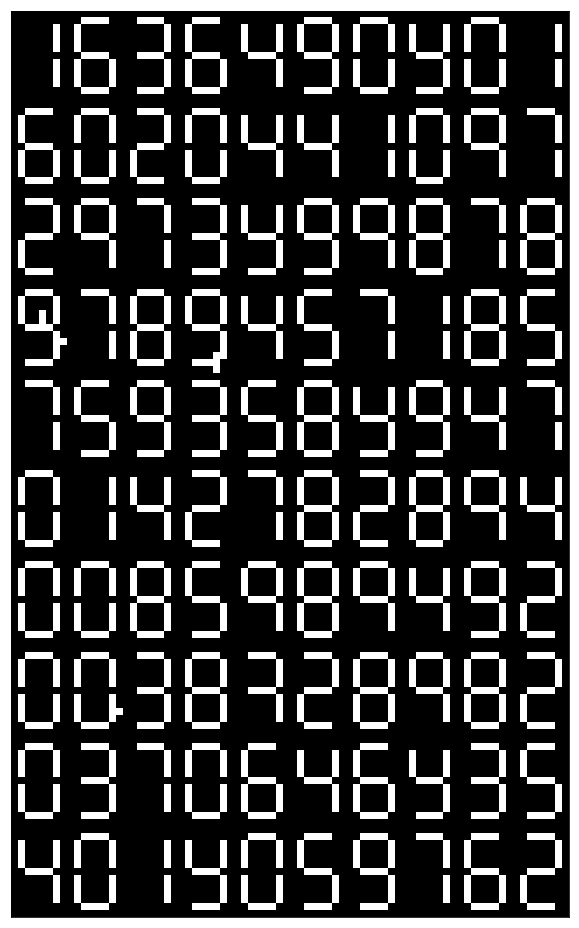

In [0]:
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else 
        np.zeros((n_samples * n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()

    cnn.train(False)
    
    for i in range(IMAGE_WIDTH):
        for j in range(IMAGE_HEIGHT):
            if i < starting_point[0]:
                continue
            if j <= starting_point[1] and i <= starting_point[0]:
                continue
            
            out = cnn(Variable(samples))
            probs = F.softmax(out, dim=1).data

            very_probs = probs.permute(0,2,3,1).contiguous().view((-1,2))
            v = torch.multinomial(very_probs, 1)
            sampled = v.view((-1, IMAGE_WIDTH, IMAGE_HEIGHT))
            
            samples[:,:,i,j] = sampled[:,i,j]
    return samples.numpy()

show_as_image(batch_images_to_one(generate_samples(n_samples=10)), figsize=(10, 20))

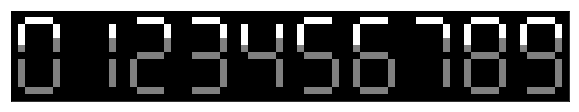

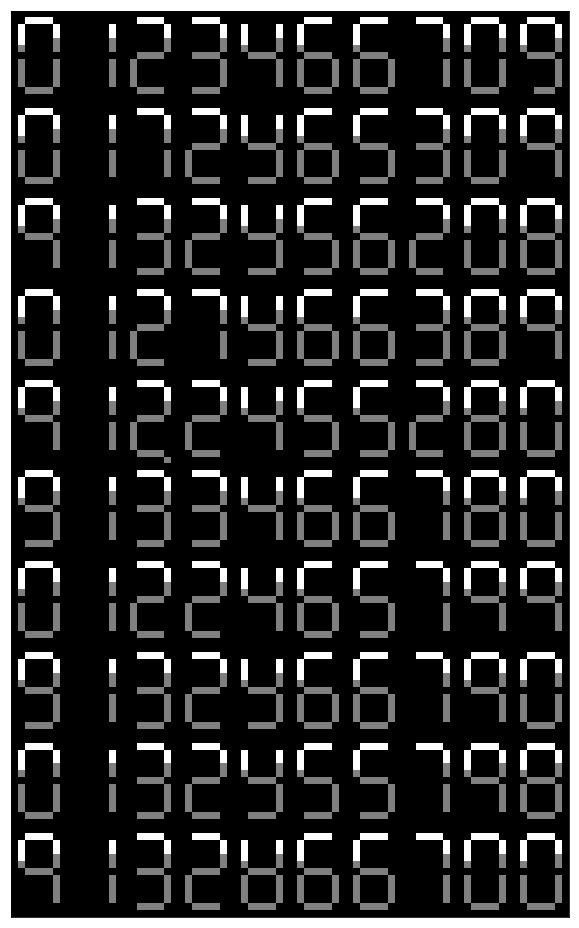

In [0]:
from utils import random_digits

n_images = 10
starting_point = (4, 3)

mask = causal_mask(IMAGE_WIDTH, IMAGE_HEIGHT, starting_point)

starting_images = digits_list = [random_digits(fixed_label=d)[0] for d in range(10)]
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(n_images, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(10, 10))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(10, 20))